In [25]:
from env import Enviroment
from evolved_agent import EvolvedAgent
from actors import Agent, Wall, Landmark
from typing import List
import numpy as np
from copy import deepcopy
from math import degrees, atan2, pi
from utils import distance_from_wall, intersection, angle_from_vector, intersection_line_circle
import torch
from nn import NN
from parameters import *
import matplotlib.pyplot as plt
from numpy import ceil

class EnvEvolution(Enviroment):
    def __init__(
        self,
        agent: EvolvedAgent,
        walls: List[Wall] = [],
        landmarks: List[Landmark] = [],
        height=800,
        width=800,
        instants=1000,
        w1=1,
        w2=1,
        w3=0.2,
        
    ):
        super().__init__(agent, walls, landmarks)
        self.height = height
        self.width = width
        self.map = np.zeros((self.width, self.height))
        self.collisions = 0
        self.movements = 0
        self.instants = instants
        self.W1 = w1
        self.W2 = w2
        self.W3 = w3
        self.distance = self.agent.max_distance * np.ones(self.instants)
        self.path = []
        self.map = np.zeros((self.width, self.height))

    def reset(self, random=False):
        if random:
            self.agent.pos = np.array(
                [np.random.randint(0, self.width), np.random.randint(0, self.height)],
                dtype=np.float64,
            )
            self.agent.direction_vector = np.array(
                [np.random.randint(-1, 2), np.random.randint(-1, 2)], dtype=np.float64
            )
        else:
            self.agent.pos = np.array([self.width // 2, self.height // 2], dtype=np.float64)
        self.collisions = 0
        self.movements = 0
        self.map = np.zeros((self.width, self.height))
        self.distance = self.agent.max_distance * np.ones(self.instants)
        self.path = []

    def move_agent(self, dt=100):
        try:
            distances = np.array([data[1][0] for data in  self.get_sensor_data(self.agent.n_sensors, self.agent.max_distance)], dtype=np.float32)
            vl, vr = self.agent.controller.forward(torch.tensor(distances, dtype=torch.float))
        except Exception as e:
            print(e)
            vl, vr = 0, 0
        v, w = (vl + vr) / 2, (vr - vl) / (self.agent.size * 2)
        dx,dy, dtheta = 0,0, w * dt
        if w == 0:
            dx = v * dt * np.cos(self.agent.direction)
            dy = v * dt * np.sin(self.agent.direction)
        else:
            R = v / w
            dx = R * (np.sin(self.agent.direction + dtheta) - np.sin(self.agent.direction))
            dy = -R * (np.cos(self.agent.direction + dtheta) - np.cos(self.agent.direction))

        dx = np.clip(dx, -10, 10)
        dy = np.clip(dy, -10, 10)
        move_vector = np.array([dx, dy])
        if move_vector[0] == 0 and move_vector[1] == 0:
            return
        for wall in self.walls:
            current_d = distance_from_wall(wall, self.agent.pos)

            if current_d <= self.agent.size:
                # Vector of the wall direction
                self.collisions += 1
                wall_vector = np.array(
                    [wall.end[0] - wall.start[0], wall.end[1] - wall.start[1]]
                )
                wall_vector = wall_vector / np.linalg.norm(wall_vector)

                # Vector of the agent parallel to the wall
                parallel_component = np.dot(wall_vector, move_vector) * wall_vector

                # Vector of the agent perpendicular to the wall
                wall_to_agent = self.agent.pos - np.array(
                    distance_from_wall(wall, self.agent.pos, coords=True)
                )
                wall_to_agent = wall_to_agent / np.linalg.norm(wall_to_agent)

                # If the agent is inside the wall push it out
                self.agent.apply_vector(wall_to_agent * (self.agent.size - current_d))
                # Check if the agent is moving towards the wall
                if np.dot(self.agent.direction_vector, -wall_to_agent) > 0:
                    # If the agent is moving towards the wall only consider the parallel component
                    move_vector = parallel_component

        # Check if the agent is making an illegal move
        for wall in self.walls:
            intersection_point = intersection(
                Wall(
                    self.agent.pos[0],
                    self.agent.pos[1],
                    self.agent.pos[0] + move_vector[0],
                    self.agent.pos[1] + move_vector[1],
                ),
                wall,
            )
            if intersection_point:
                print("ILLEGAL MOVE")
                return
            
            
        print(f"dx: {dx}, dy: {dy}, dtheta: {dtheta}")
            
        self.agent.apply_vector(move_vector)
        # Set visited positions to 1 within -10 to +10 range around agent's position
        x_start = max(0, int(self.agent.pos[0]) - 10)
        x_end = min(self.map.shape[0], int(self.agent.pos[0]) + 10 + 1)
        y_start = max(0, int(self.agent.pos[1]) - 10)
        y_end = min(self.map.shape[1], int(self.agent.pos[1]) + 10 + 1)

        # Efficiently set the range using numpy slicing
        self.map[x_start:x_end, y_start:y_end] = 1

        # Append the new position to the path
        self.path.append((self.agent.pos[0], self.agent.pos[1]))

        # Rotate the agent
        self.agent.rotate(np.deg2rad(dtheta))

    def fitness_score(self) -> float:
        return (
            self.explored_terrain * 100
            #np.mean(1 / self.distance)
            #+ np.exp(-self.collisions)
        )
    @property
    def explored_terrain(self) -> float:
        return np.sum(self.map) / (self.width * self.height)

    def visualize_movement(self):
        if self.path == []:
            return
        plt.figure(figsize=(10, 10))
        plt.imshow(self.map.T, origin='lower', cmap='gray_r')
        plt.colorbar(label='Explored')
        plt.scatter(self.agent.pos[0], self.agent.pos[1], color='red', s=100, label='Agent')
        for wall in self.walls:
            plt.plot([wall.start[0], wall.end[0]], [wall.start[1], wall.end[1]], 'b-', linewidth=2)
        path = np.array(self.path)
        plt.plot(path[:, 0], path[:, 1], 'r-', label='Path')
        plt.title('Agent Movement and Explored Terrain')
        plt.xlabel('Width')
        plt.ylabel('Height')
        plt.legend()
        plt.show()


initial pos [341. 108.]
dx: 3.998106410541308, dy: 4.123065551591411, dtheta: 183.81394147872925
dx: -3.5078064946730487, dy: -2.6652903117011304, dtheta: 82.84778594970703
dx: 0.28238317171326477, dy: -1.726156687696588, dtheta: 38.13994824886322
dx: -0.6252248841625136, dy: 3.1278267684148533, dtheta: 49.4452565908432
dx: -3.4103691169408736, dy: 5.193825297284096, dtheta: 180.43363094329834
dx: -0.2669468610983572, dy: 0.015877497101579596, dtheta: 94.31464672088623
dx: 7.384511680249055, dy: -2.2010867070772835, dtheta: 40.29641151428223
dx: 3.2522078409200783, dy: -1.463867395906421, dtheta: 57.472825050354004
dx: -2.654437187245819, dy: 0.6205492695730399, dtheta: 175.23375749588013
dx: 4.02781060691867, dy: -4.936092136567292, dtheta: 86.12208366394043
dx: 7.934514406880583, dy: -0.8401862620759473, dtheta: 34.412139654159546
dx: 7.350581935090251, dy: 1.7343800065895907, dtheta: 46.4517205953598
dx: -0.23218613127049792, dy: 0.0524142321901504, dtheta: 188.4360432624817
dx: 3.1

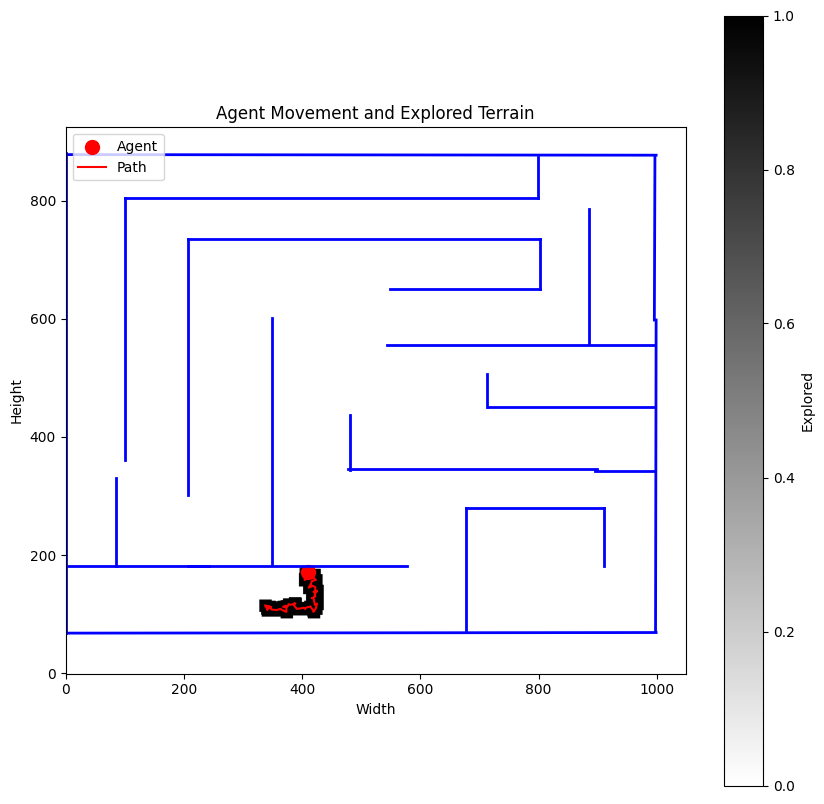

final pos  [410. 172.] collisions 0 explored terrain 0.008190625 fitness 1.013190625
[(345.0, 112.0), (341.0, 109.0), (341.0, 107.0), (340.0, 110.0), (337.0, 115.0), (337.0, 115.0), (344.0, 113.0), (347.0, 112.0), (344.0, 113.0), (348.0, 108.0), (356.0, 107.0), (363.0, 109.0), (363.0, 109.0), (366.0, 107.0), (373.0, 104.0), (373.0, 106.0), (373.0, 114.0), (368.0, 113.0), (368.0, 112.0), (375.0, 113.0), (377.0, 117.0), (380.0, 116.0), (388.0, 118.0), (387.0, 119.0), (386.0, 115.0), (386.0, 115.0), (391.0, 109.0), (398.0, 110.0), (402.0, 111.0), (405.0, 109.0), (406.0, 111.0), (413.0, 113.0), (414.0, 113.0), (418.0, 107.0), (419.0, 104.0), (423.0, 110.0), (425.0, 118.0), (421.0, 116.0), (421.0, 117.0), (420.0, 123.0), (419.0, 127.0), (416.0, 127.0), (422.0, 130.0), (421.0, 132.0), (422.0, 134.0), (421.0, 134.0), (425.0, 140.0), (425.0, 139.0), (419.0, 138.0), (422.0, 138.0), (422.0, 146.0), (415.0, 149.0), (416.0, 147.0), (411.0, 145.0), (415.0, 152.0), (416.0, 156.0), (416.0, 156.0), (4

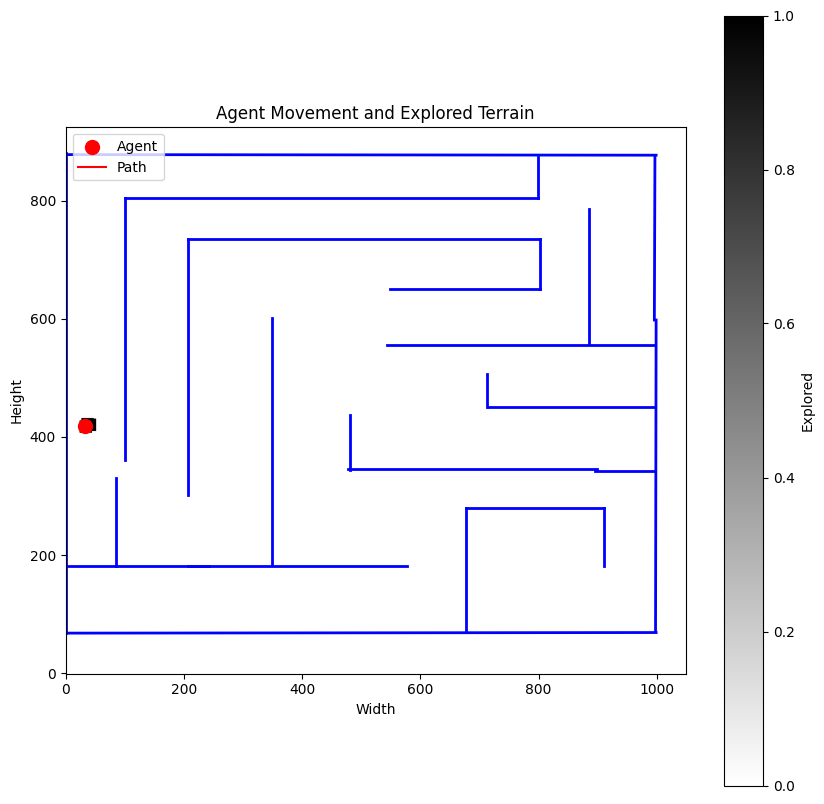

final pos  [ 33. 418.] collisions 0 explored terrain 0.0010359375 fitness 1.0060359375
[(40.0, 421.0), (37.0, 421.0), (36.0, 422.0), (33.0, 418.0)]
initial pos [205. 142.]
dx: -0.10294975772353127, dy: 7.998674948953049, dtheta: 22.016888856887817
dx: -2.6460114587141725, dy: 10.0, dtheta: 9.113827347755432
dx: -9.120716412282523, dy: 1.7223762894996393, dtheta: 11.106415092945099


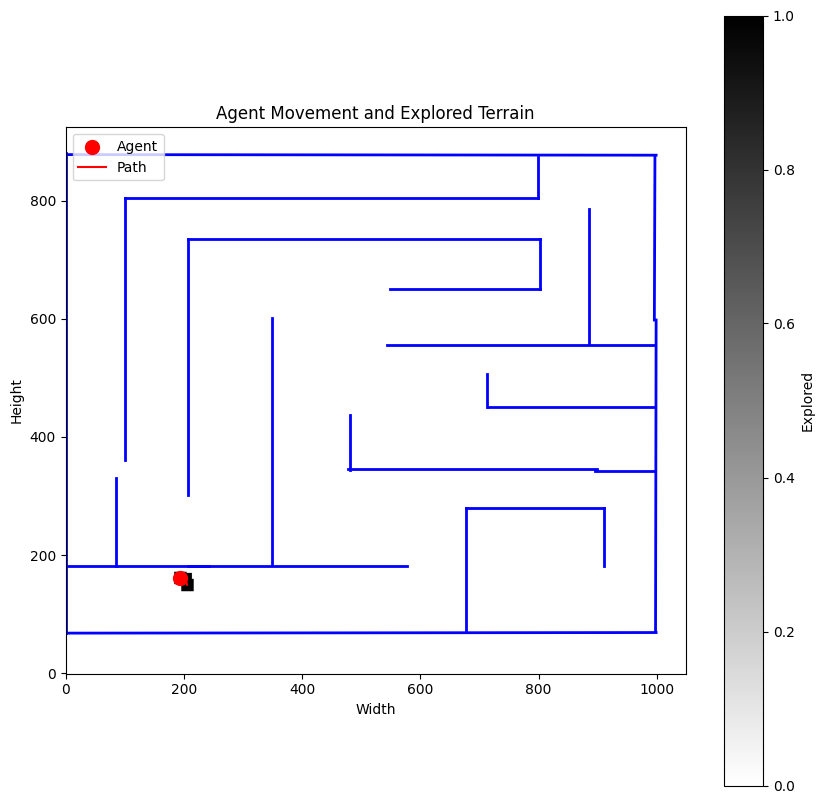

final pos  [193. 162.] collisions 0 explored terrain 0.0014015625 fitness 1.0064015625
[(205.0, 150.0), (202.0, 160.0), (193.0, 162.0)]
initial pos [238. 444.]
dx: -0.3922139291603271, dy: 0.01927541347399675, dtheta: 188.3973479270935
dx: -3.039988498631084, dy: -8.286015913257595, dtheta: 134.0920925140381
dx: 6.258716235744501, dy: 1.9965225641931146, dtheta: 108.74110460281372
dx: 10.0, dy: 10.0, dtheta: -0.38210153579711914
dx: -2.0010852067288223, dy: -7.588862164965017, dtheta: -18.696677684783936
dx: -10.0, dy: 10.0, dtheta: 27.25921869277954
dx: -10.0, dy: 10.0, dtheta: 15.718895196914673
dx: -10.0, dy: 10.0, dtheta: 45.180320739746094
dx: 0.5008231630257826, dy: -10.0, dtheta: 80.01936078071594
dx: 4.709251180892308, dy: -10.0, dtheta: 165.76191186904907
dx: 1.9448180453577075, dy: 5.102367783375248, dtheta: 221.41399383544922
dx: 10.0, dy: 10.0, dtheta: 11.374354362487793
dx: 10.0, dy: 0.17808587186640681, dtheta: 28.6668062210083
dx: -0.6155270808393439, dy: 2.9213811532973

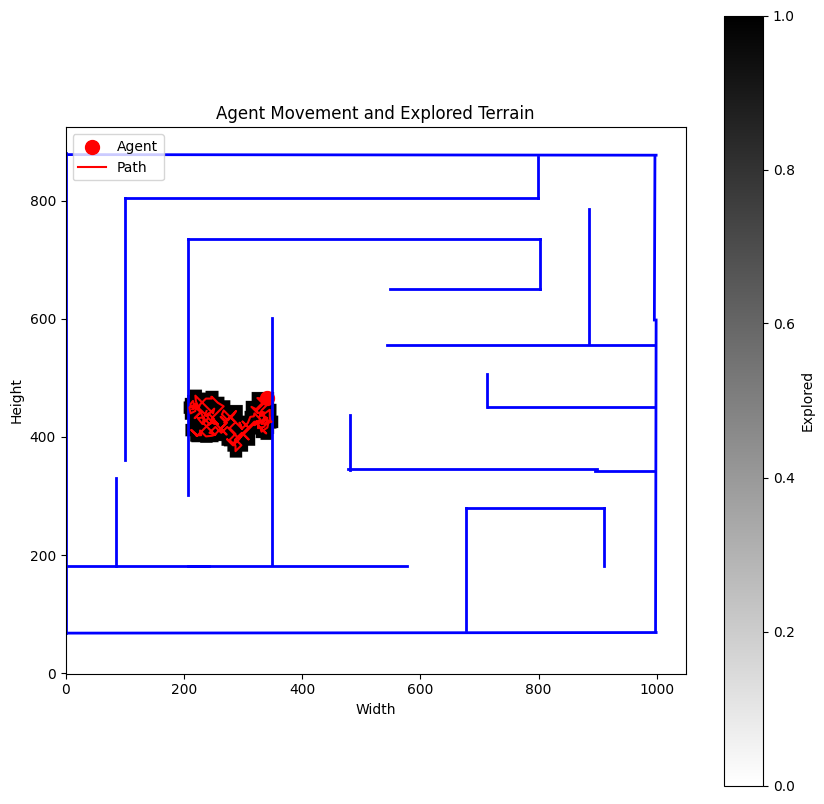

final pos  [341. 466.] collisions 10 explored terrain 0.019890625 fitness 0.024936024929762483
[(238.0, 444.0), (235.0, 436.0), (241.0, 438.0), (251.0, 448.0), (249.0, 440.0), (239.0, 450.0), (229.0, 460.0), (219.0, 470.0), (220.0, 460.0), (225.0, 450.0), (227.0, 455.0), (237.0, 465.0), (247.0, 465.0), (246.0, 468.0), (247.0, 468.0), (257.0, 458.0), (267.0, 452.0), (257.0, 442.0), (247.0, 432.0), (257.0, 422.0), (247.0, 432.0), (251.0, 422.0), (241.0, 432.0), (231.0, 422.0), (223.0, 432.0), (233.0, 433.0), (232.0, 424.0), (242.0, 414.0), (252.0, 404.0), (262.0, 414.0), (272.0, 424.0), (262.0, 434.0), (272.0, 424.0), (262.0, 414.0), (272.0, 404.0), (262.0, 414.0), (252.0, 424.0), (253.0, 426.0), (243.0, 422.0), (233.0, 432.0), (228.0, 442.0), (218.0, 432.0), (228.0, 442.0), (218.0, 451.0), (215.0, 461.0), (211.0, 456.0), (211.0, 451.0), (220.0, 455.0), (219.0, 455.0), (209.0, 450.0), (211.0, 440.0), (213.0, 441.0), (219.0, 444.0), (219.0, 452.0), (214.0, 447.0), (220.0, 453.0), (230.0, 

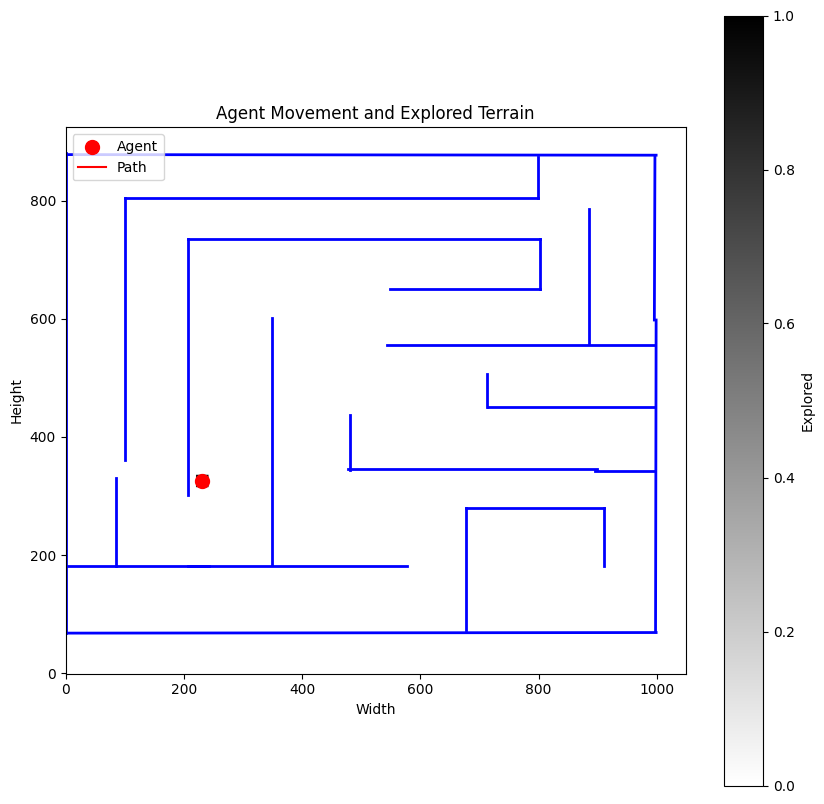

final pos  [230. 326.] collisions 0 explored terrain 0.0006890625 fitness 1.0056890625
[(230.0, 326.0)]
initial pos [379. 103.]
dx: -3.9257473496192663, dy: -10.0, dtheta: -72.91375398635864
dx: 4.8580357408546995, dy: 5.593041447839213, dtheta: 123.63691255450249
dx: -4.344732995231725, dy: -1.2679418254327857, dtheta: 124.46103096008301
dx: 4.206911781468662, dy: -5.712008657961526, dtheta: 61.127977818250656
dx: 1.075198173211131, dy: -5.523756059391859, dtheta: 102.091383934021
dx: -10.0, dy: -3.2714125646534176, dtheta: -30.345529317855835
dx: -0.868285606969934, dy: 1.7263457619749085, dtheta: 118.98407340049744
dx: -3.5026847178013782, dy: 5.556145109893943, dtheta: 121.30687236785889
dx: 4.35316537650273, dy: -5.28776427145926, dtheta: 85.90908646583557
dx: 0.4473041123852554, dy: -2.1640306680747243, dtheta: 44.241321086883545
dx: 8.535316110293712, dy: 10.0, dtheta: 53.92836928367615
dx: -1.4166294812535432, dy: 10.0, dtheta: 21.645909547805786
dx: -1.7573277965597356, dy: -0

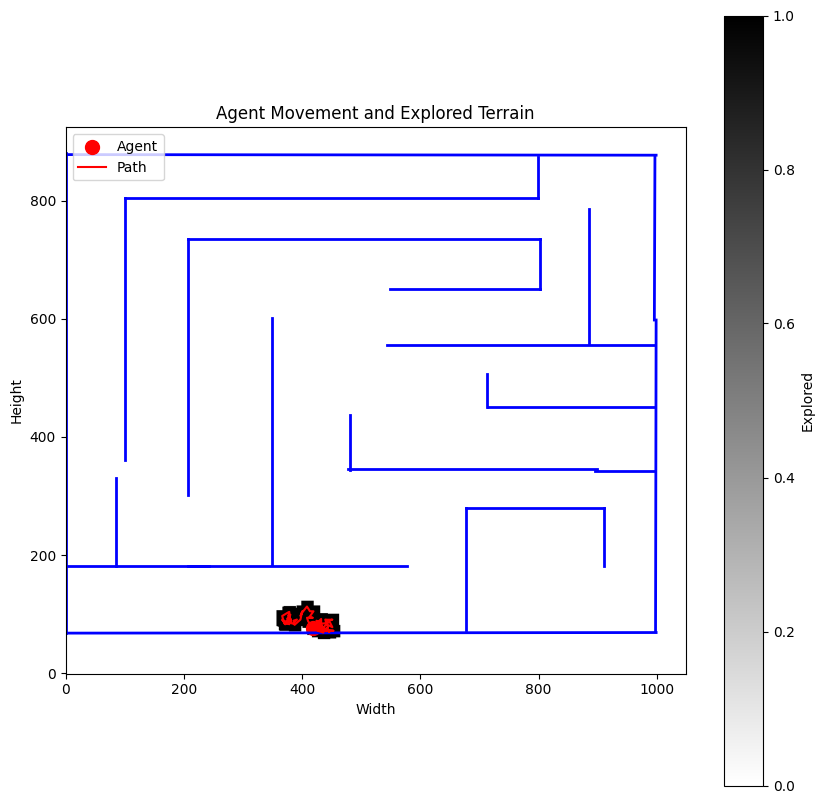

final pos  [418.  76.] collisions 14 explored terrain 0.0075203125 fitness 0.012521144028719103
[(375.0, 93.0), (380.0, 99.0), (376.0, 98.0), (380.0, 92.0), (381.0, 86.0), (371.0, 83.0), (370.0, 85.0), (366.0, 91.0), (370.0, 86.0), (370.0, 84.0), (379.0, 94.0), (378.0, 104.0), (376.0, 103.0), (366.0, 97.0), (368.0, 90.0), (378.0, 83.0), (378.0, 85.0), (381.0, 91.0), (375.0, 91.0), (376.0, 88.0), (374.0, 87.0), (384.0, 84.0), (391.0, 91.0), (385.0, 89.0), (387.0, 82.0), (397.0, 91.0), (399.0, 101.0), (400.0, 105.0), (397.0, 97.0), (400.0, 103.0), (408.0, 113.0), (408.0, 113.0), (413.0, 105.0), (419.0, 105.0), (412.0, 95.0), (418.0, 94.0), (408.0, 94.0), (410.0, 88.0), (417.0, 78.0), (424.0, 85.0), (423.0, 83.0), (426.0, 76.0), (436.0, 69.0), (426.0, 72.0), (428.0, 72.0), (435.0, 72.0), (431.0, 79.0), (434.0, 75.0), (441.0, 71.0), (431.0, 82.0), (426.0, 82.0), (418.0, 80.0), (422.0, 77.0), (432.0, 86.0), (432.0, 92.0), (429.0, 89.0), (432.0, 82.0), (432.0, 84.0), (442.0, 85.0), (441.0, 9

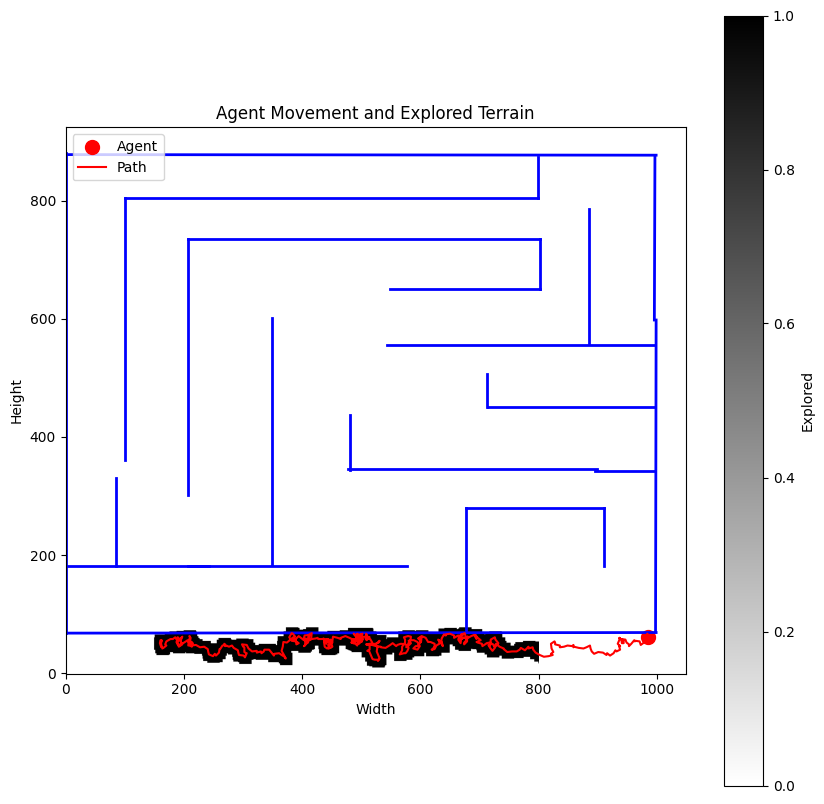

final pos  [985.  62.] collisions 24 explored terrain 0.03938125 fitness 0.04438125003775134
[(161.0, 45.0), (159.0, 51.0), (160.0, 56.0), (162.0, 55.0), (162.0, 56.0), (161.0, 50.0), (163.0, 43.0), (163.0, 42.0), (165.0, 43.0), (170.0, 47.0), (168.0, 49.0), (170.0, 54.0), (177.0, 58.0), (181.0, 58.0), (185.0, 61.0), (189.0, 54.0), (190.0, 47.0), (187.0, 53.0), (193.0, 58.0), (197.0, 62.0), (197.0, 62.0), (194.0, 55.0), (189.0, 61.0), (193.0, 56.0), (197.0, 49.0), (191.0, 45.0), (193.0, 49.0), (200.0, 52.0), (200.0, 52.0), (206.0, 56.0), (206.0, 54.0), (213.0, 53.0), (215.0, 50.0), (208.0, 53.0), (209.0, 51.0), (211.0, 52.0), (214.0, 48.0), (207.0, 47.0), (208.0, 55.0), (210.0, 61.0), (209.0, 63.0), (211.0, 60.0), (210.0, 53.0), (209.0, 48.0), (209.0, 48.0), (213.0, 45.0), (213.0, 47.0), (220.0, 48.0), (220.0, 48.0), (227.0, 44.0), (234.0, 45.0), (240.0, 41.0), (241.0, 36.0), (242.0, 32.0), (249.0, 29.0), (252.0, 33.0), (254.0, 30.0), (259.0, 35.0), (260.0, 41.0), (261.0, 41.0), (265.0

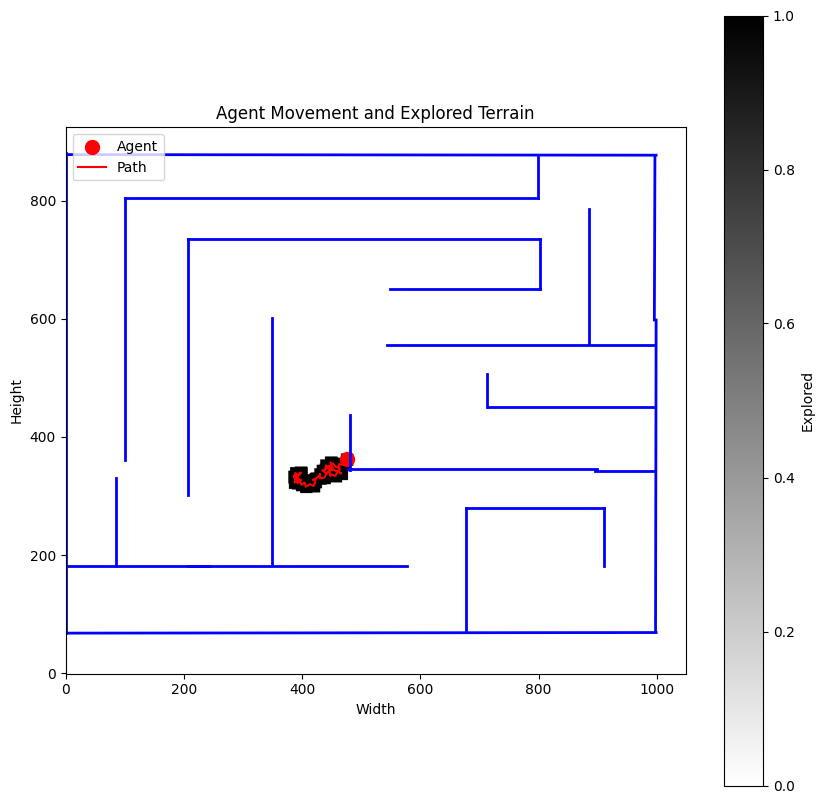

final pos  [475. 362.] collisions 0 explored terrain 0.007021875 fitness 1.012021875
[(393.0, 334.0), (398.0, 339.0), (397.0, 340.0), (391.0, 335.0), (392.0, 329.0), (395.0, 327.0), (394.0, 329.0), (388.0, 328.0), (393.0, 326.0), (391.0, 332.0), (392.0, 322.0), (398.0, 327.0), (392.0, 327.0), (387.0, 323.0), (392.0, 329.0), (387.0, 332.0), (386.0, 332.0), (389.0, 339.0), (386.0, 333.0), (390.0, 325.0), (388.0, 331.0), (391.0, 326.0), (397.0, 323.0), (399.0, 319.0), (404.0, 323.0), (406.0, 316.0), (413.0, 320.0), (419.0, 317.0), (422.0, 324.0), (422.0, 329.0), (418.0, 327.0), (424.0, 330.0), (430.0, 336.0), (430.0, 337.0), (430.0, 330.0), (437.0, 331.0), (441.0, 338.0), (435.0, 343.0), (434.0, 343.0), (440.0, 345.0), (439.0, 345.0), (440.0, 352.0), (441.0, 351.0), (447.0, 346.0), (441.0, 349.0), (448.0, 345.0), (445.0, 351.0), (448.0, 346.0), (451.0, 345.0), (446.0, 343.0), (440.0, 338.0), (441.0, 338.0), (441.0, 338.0), (446.0, 342.0), (448.0, 334.0), (448.0, 337.0), (456.0, 334.0), (4

In [26]:
for simulation in range(10):
    
    env = EnvEvolution(
        EvolvedAgent(controller=NN(), n_sensors=12, max_distance=200, size=4),
        instants=10000,
        w1=1,
        w2=1,
        w3=0.2,
    )
    env.load_walls(WALLS_TXT)
    
    # Initialize agent's position ensuring it's not within a wall
    valid_position = False
    while not valid_position:
        x, y = float(np.random.randint(10, 790)), float(np.random.randint(10, 790))
        valid_position = all(distance_from_wall(wall, [x, y]) > 5 for wall in env.walls)
    env.agent.pos = np.array([x, y], dtype=np.float64)
    
    print("initial pos", env.agent.pos)
    
    for step in range(2000):
        env.move_agent()
    
    env.visualize_movement()
    fitness = env.fitness_score()
    print("final pos ", env.agent.pos, "collisions", env.collisions, "explored terrain", env.explored_terrain, "fitness", fitness)
    print(env.path)
